In [2]:
import os, sys, re
from functools import partial

import scipy
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import shap

import dproc, sgml, sgutil

print(sys.version)
for i in [scipy, sklearn, mpl, sns, np, pd, pl, cb, lgb, xgb, shap]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
scipy 1.14.0
sklearn 1.5.1
matplotlib 3.9.1.post1
seaborn 0.13.2
numpy 1.26.4
pandas 2.2.2
polars 1.17.1
catboost 1.2.7
lightgbm 4.5.0
xgboost 2.1.1
shap 0.46.0


# Data acquirement

In [4]:
data_path = 'data'
if not os.path.isdir(data_path):
    os.mkdir(data_path)
files = {
    k: os.path.join(p, f)
    for k, p, f in [
        ('train', data_path, 'train.csv'),
        ('test', data_path, 'test.csv'),
        ('org', data_path, 'org.csv'),
        ('train_parquet', data_path, 'train.parquet'),
        ('test_parquet', data_path, 'test.parquet'),
        ('org_parquet', data_path, 'org.parquet'),
        ('var_pkl', data_path, 'var.pkl')
    ]
}

if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['var_pkl'])):
    !kaggle competitions download -c playground-series-s4e12
    !mkdir data
    !unzip playground-series-s4e12.zip -d data
    !rm playground-series-s4e12.zip
    !kaggle datasets download -d schran/insurance-premium-prediction
    !unzip insurance-premium-prediction.zip
    !mv "Insurance Premium Prediction Dataset.csv" "data/org.csv"
    !rm insurance-premium-prediction.zip

In [5]:
if not os.path.exists(files['var_pkl']):
    features = """
    1. Age: Age of the insured individual (Numerical)
    2. Gender: Gender of the insured individual (Categorical: Male, Female)
    3. Annual Income: Annual income of the insured individual (Numerical, skewed)
    4. Marital Status: Marital status of the insured individual (Categorical: Single, Married, Divorced)
    5. Number of Dependents: Number of dependents (Numerical, with missing values)
    6. Education Level: Highest education level attained (Categorical: High School, Bachelor's, Master's, PhD)
    7. Occupation: Occupation of the insured individual (Categorical: Employed, Self-Employed, Unemployed)
    8. Health Score: A score representing the health status (Numerical, skewed)
    9. Location: Type of location (Categorical: Urban, Suburban, Rural)
    10. Policy Type: Type of insurance policy (Categorical: Basic, Comprehensive, Premium)
    11. Previous Claims: Number of previous claims made (Numerical, with outliers)
    12. Vehicle Age: Age of the vehicle insured (Numerical)
    13. Credit Score: Credit score of the insured individual (Numerical, with missing values)
    14. Insurance Duration: Duration of the insurance policy (Numerical, in years)
    15. Premium Amount: Target variable representing the insurance premium amount (Numerical, skewed)
    16. Policy Start Date: Start date of the insurance policy (Text, improperly formatted)
    17. Customer Feedback: Short feedback comments from customers (Text)
    18. Smoking Status: Smoking status of the insured individual (Categorical: Yes, No)
    19. Exercise Frequency: Frequency of exercise (Categorical: Daily, Weekly, Monthly, Rarely)
    20. Property Type: Type of property owned (Categorical: House, Apartment, Condo)
    """
    df_var = pd.DataFrame(
        [pd.Series(re.findall("[0-9]+. (?P<name>[^:]+): (?P<desc>.+)", i)[0], index=['name', 'Description']) for i in features.split('\n') if len(i) != 0],
    ).set_index('name')
    df_type = dproc.merge_type_df([
        pl.scan_csv(files[i]).pipe(dproc.get_type_df) for i in ['train', 'test', 'org']
    ])
    pl_type = dproc.get_type_pl(
        df_type, 
        {
            'Smoking Status': pl.Categorical, 'Gender': pl.Categorical, 'Marital Status': pl.Categorical, 'Education Level': pl.Categorical,
            'Occupation': pl.Categorical, 'Location': pl.Categorical, 'Policy Type': pl.Categorical, 'Smoking Status': pl.Categorical,
            'Exercise Frequency': pl.Categorical, 'Property Type': pl.Categorical
        }
    )
    df_var = pd.concat([
        df_var,
        df_type,
        pd.Series(pl_type, name = 'pl_type')
    ], axis=1)
    df_var
    pl.scan_csv('data/train.csv', schema_overrides = pl_type).sink_parquet(files['train_parquet'])
    pl.scan_csv('data/test.csv', schema_overrides = pl_type).sink_parquet(files['test_parquet'])
    pl.scan_csv('data/org.csv', schema_overrides = pl_type).sink_parquet(files['org_parquet'])
    df_var.to_pickle(files['var_pkl'])
    !rm data/train.csv
    !rm data/test.csv
    !rm data/org.csv
df_var = pd.read_pickle(files['var_pkl'])
sc = sgutil.SGCache('img', 'result')

# Polars Processing

In [6]:
df_train = pl.read_parquet(files['train_parquet'])
df_test = pl.read_parquet(files['test_parquet'])
df_org = pl.read_parquet(files['org_parquet'])

In [7]:
ord_list = [
    ('Education Level', {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}),
    ('Location', {"Rural": 0, "Suburban": 1, "Urban": 2}),
    ('Policy Type', {'Basic': 0, 'Comprehensive': 1, 'Premium': 2}),
    ('Exercise Frequency', {'Daily': 0, 'Weekly': 1, 'Monthly': 2, 'Rarely': 3}),
    ('Customer Feedback', {'Poor': 0, 'Average': 1, 'Good': 2}),
]

proc_list=[
    (i, pl.col(i).cast(pl.String).replace(d).cast(pl.Int8), ['{}: {}'.format(k, v) for k, v in d.items()])
    for i, d in ord_list 
]
proc_list += [
    ('Smoking Status', (pl.col('Smoking Status') == 'Yes').cast(pl.Int8), '0: No, 1: Yes'),
    ('Gender', (pl.col('Gender') == 'Male').cast(pl.Int8), '0: Female, 1: Male')
]

In [8]:
df_train, df_var_proc = dproc.apply_with_columns(df_train, proc_list, 'org')
df_var = pd.concat([
    df_var,
    df_var_proc
], axis = 0).assign(
    src = lambda x: x['src'].fillna('org')
).groupby(level=0).last()
df_test = dproc.apply_with_columns(df_test, proc_list)
df_org = dproc.apply_with_columns(df_org, proc_list)

In [9]:
pd_vars= dproc.PD_Vars.load_or_create(os.path.join('data', 'vars') , df_var)

In [10]:
df_train = df_train.to_pandas().set_index('id')
df_test = df_test.to_pandas().set_index('id')
df_org = df_org.to_pandas()
df_train = pd_vars.put_proc('org', df_train, [(lambda x: pd.to_datetime(x['Policy Start Date']), 'Start date of the insurance policy')])
df_test, _ = pd_vars.procs_all(df_test)
df_org , _= pd_vars.procs_all(df_org)
pd_vars.save()

In [11]:
pd_vars.df_var

,Description,min,max,na,count,n_unique,dtype,f32,i32,i16,i8,src
Age,Age of the insured individual (Numerical),18.0,64.0,35879.0,2242981.0,48.000000,Float64,1.0,1.0,1.0,1.0,org
Annual Income,Annual income of the insured individual (Numer...,0.0,149997.0,88764.0,2190096.0,90335.000000,Float64,1.0,1.0,0.0,0.0,org
Credit Score,Credit score of the insured individual (Numeri...,300.0,849.0,257219.0,2021641.0,551.000000,Float64,1.0,1.0,1.0,0.0,org
Customer Feedback,"[Poor: 0, Average: 1, Good: 2]",0.0,2.0,77824.0,1122176.0,4.000000,Int8,1.0,1.0,1.0,1.0,org
Education Level,"[High School: 0, Bachelor's: 1, Master's: 2, P...",0.0,3.0,0.0,1200000.0,4.000000,Int8,1.0,1.0,1.0,1.0,org
Exercise Frequency,"[Daily: 0, Weekly: 1, Monthly: 2, Rarely: 3]",0.0,3.0,0.0,1200000.0,4.000000,Int8,1.0,1.0,1.0,1.0,org
Gender,"0: Female, 1: Male",0.0,1.0,0.0,1200000.0,2.000000,Int8,1.0,1.0,1.0,1.0,org
Health Score,A score representing the health status (Numeri...,0.035436,93.87609,134122.0,2144738.0,396543.000000,Float64,1.0,1.0,1.0,1.0,org
Insurance Duration,"Duration of the insurance policy (Numerical, i...",1.0,9.0,3.0,2278857.0,9.666667,Int64,1.0,1.0,1.0,1.0,org
Location,"[Rural: 0, Suburban: 1, Urban: 2]",0.0,2.0,0.0,1200000.0,3.000000,Int8,1.0,1.0,1.0,1.0,org


In [12]:
X_bool = ['Gender', 'Smoking Status']
X_ord = ['Education Level', 'Location', 'Policy Type', 'Exercise Frequency']
X_nom = ['Marital Status', 'Occupation', 'Property Type']
X_cat = X_bool + X_ord + X_nom
X_num = ['Age', 'Annual Income', 'Credit Score', 'Insurance Duration', 'Health Score', 'Number of Dependents', 'Previous Claims', 'Vehicle Age']

In [13]:
df_train['Premium Amount_l'] = np.log(df_train['Premium Amount'])
target = 'Premium Amount_l'

# Target Distribution

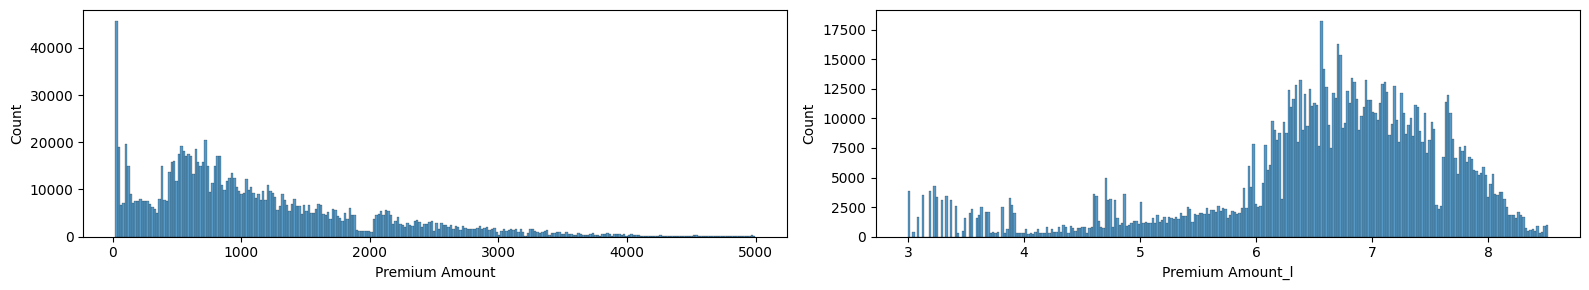

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))
sns.histplot(df_train['Premium Amount'], ax=axes[0])
sns.histplot(df_train['Premium Amount_l'], ax=axes[1])
plt.tight_layout()
plt.show()

In [15]:
df_train[target].agg(['min', 'max', 'median', 'mean']), df_train[target].mode()[0]

(min       2.995732
 max       8.516994
 median    6.770790
 mean      6.590527
 Name: Premium Amount_l, dtype: float32,
 3.218876)

In [16]:
df_train[target].value_counts().iloc[:10]

Premium Amount_l
3.218876    4268
3.178054    3901
2.995732    3849
3.135494    3524
3.332205    3418
3.258096    3375
3.871201    3307
3.367296    3139
4.605170    3125
3.295837    3074
Name: count, dtype: int64

# Categorical Variables

In [17]:
from scipy.stats import kruskal, chi2_contingency
from scipy.spatial.distance import cdist, pdist, squareform

In [18]:
pd.concat([
    df_train[i].value_counts().to_frame().pipe(lambda x: x.set_index(pd.MultiIndex.from_product([[i], x.index.tolist()], names=['Var', 'Cat'])))
    for i in X_nom
], axis = 0)

count
Var            Cat                  
Marital Status Single         395391
               Married        394316
               Divorced       391764
Occupation     Employed       282750
               Self-Employed  282645
               Unemployed     276530
Property Type  House          400349
               Apartment      399978
               Condo          399673

In [19]:
df_kruskal_tgt = sc.cache_result(
    'kruskal_tgt',
    lambda : pd.concat([
        pd.Series(
            kruskal(*df_train.groupby(i, observed=True)[target].agg(list)), index = ['stat', 'pvalue'], name = i
        )
        for i in X_bool + X_ord + X_nom
    ], axis=1)
)
df_kruskal_tgt.sort_values('pvalue', axis=1, ascending=True)

,Occupation,Location,Education Level,Policy Type,Property Type,Exercise Frequency,Marital Status,Smoking Status,Gender
stat,6.276566,3.429708,3.804265,1.907457,1.738442,2.756426,1.167640,0.169736,0.017928
pvalue,0.043357,0.179990,0.283390,0.385302,0.419278,0.430723,0.557764,0.680346,0.893486


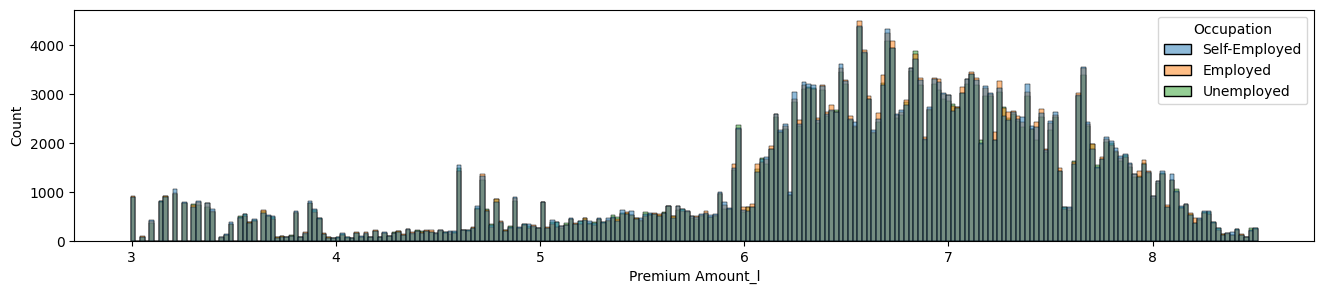

In [20]:
plt.figure(figsize=(16, 3))
sns.histplot(df_train, x=target ,hue='Occupation')
plt.show()

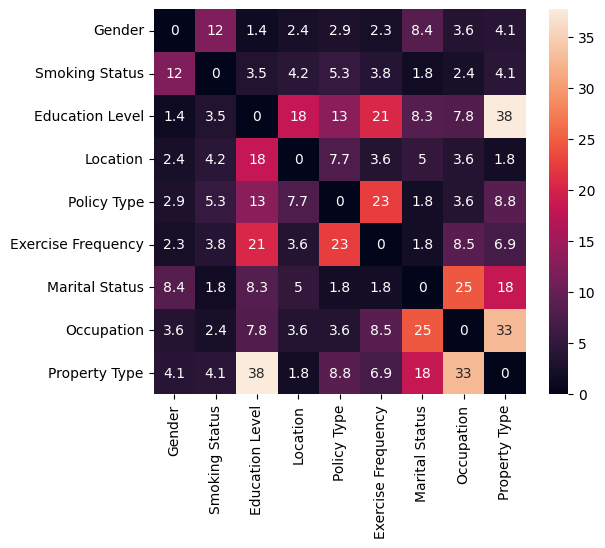

In [21]:
plt.figure(figsize=(6, 5))
df_chi2 = sc.cache_result(
    'chi2_stat',
    lambda : pd.DataFrame(
        squareform(pdist(df_train[X_cat].T, lambda u, v: chi2_contingency(pd.crosstab(index=u, columns = v))[0])),
        index = X_cat, columns=X_cat
    )
)
sns.heatmap(df_chi2, annot=True)
plt.show()

# Numeric Variables

In [22]:
from scipy.stats import kruskal, spearmanr

# Policy Start Date에서 Policy가 적용된 기간을 Policy의 최대값에서 도출합니다.
if 'Policy Days' not in df_train.columns:
    df_train['Policy Days'] = (df_train['Policy Start Date'].max() - df_train['Policy Start Date']).dt.days
    df_test['Policy Days'] = (df_train['Policy Start Date'].max() - df_test['Policy Start Date']).dt.days
    df_org['Policy Days'] = (df_train['Policy Start Date'].max() - df_org['Policy Start Date']).dt.days
    X_num.append('Policy Days') 

## Spearman with target

In [23]:
df_spearman_target = sc.cache_result('spearman_target',
    lambda : pd.concat([
        pd.Series(
            df_train[[i, target]].dropna().pipe(lambda x: spearmanr(x[i], x[target])),
            index = ['stat', 'pvalue'], name = i
        )
        for i in X_num
    ], axis=1)
).sort_values('pvalue', ascending=True, axis=1)
df_spearman_target

,Annual Income,Credit Score,Previous Claims,Health Score,Policy Days,Age,Number of Dependents,Vehicle Age,Insurance Duration
stat,-0.061437,-0.043928,0.044549,1.601483e-02,1.018274e-02,-0.002329,-0.001610,0.000870,-0.000071
pvalue,0.000000,0.000000,0.000000,9.044248e-65,6.775903e-29,0.011369,0.092669,0.340707,0.937799


## Spearman between variables

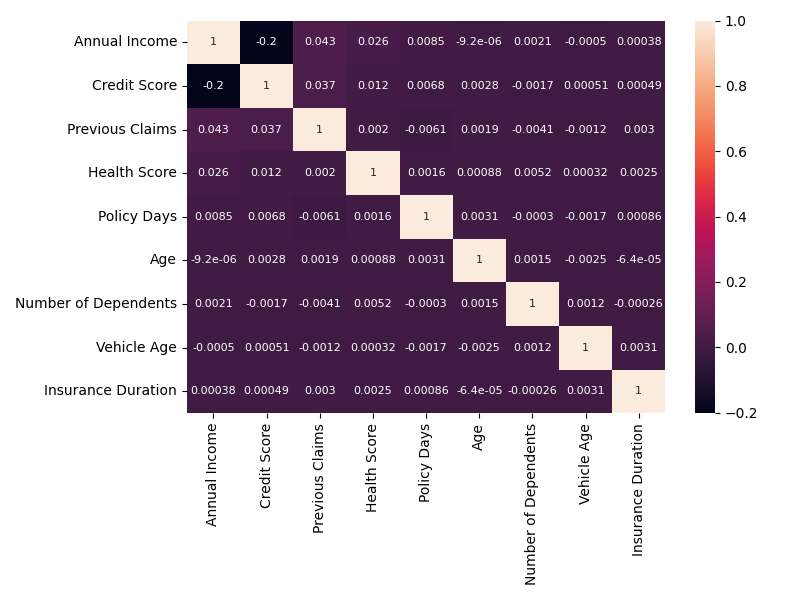

In [24]:
sc.cache_fig('spearman_between variables',
    lambda x: sns.heatmap(
        df_train[
            df_spearman_target.T['pvalue'].sort_values(ascending=True).index
        ].corr(), annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 6)
)

## Kruskal with Categorical Variables

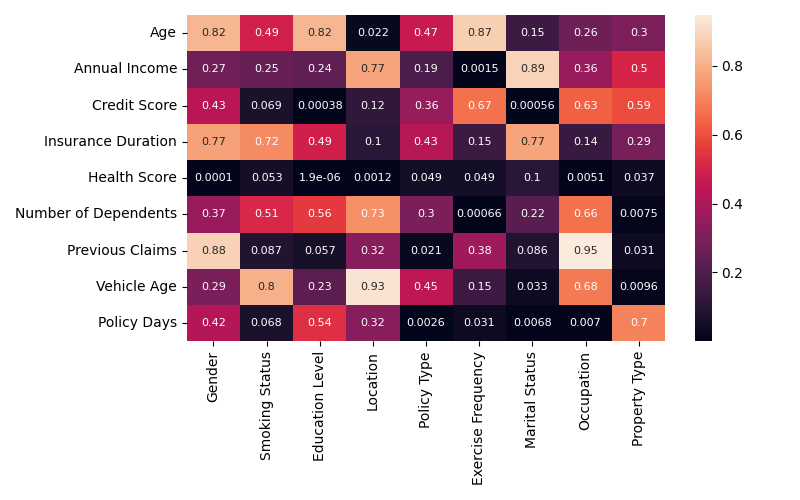

In [25]:
df_kruskal_cat = sc.cache_result('kruskal_cat', 
    lambda : pd.concat([
        df_train.groupby(df_train[i], observed=True)[X_num].agg(lambda x: x.dropna().tolist()).apply(
            lambda x: kruskal(*x).pvalue, axis=0
        ).rename(i)
        for i in X_cat
    ], axis = 1)
)

sc.cache_fig('kruskal_cat',
    lambda x: sns.heatmap(
        df_kruskal_cat, annot = True, ax = x, annot_kws = {'size': 8}
    ), figsize = (8, 5)
)

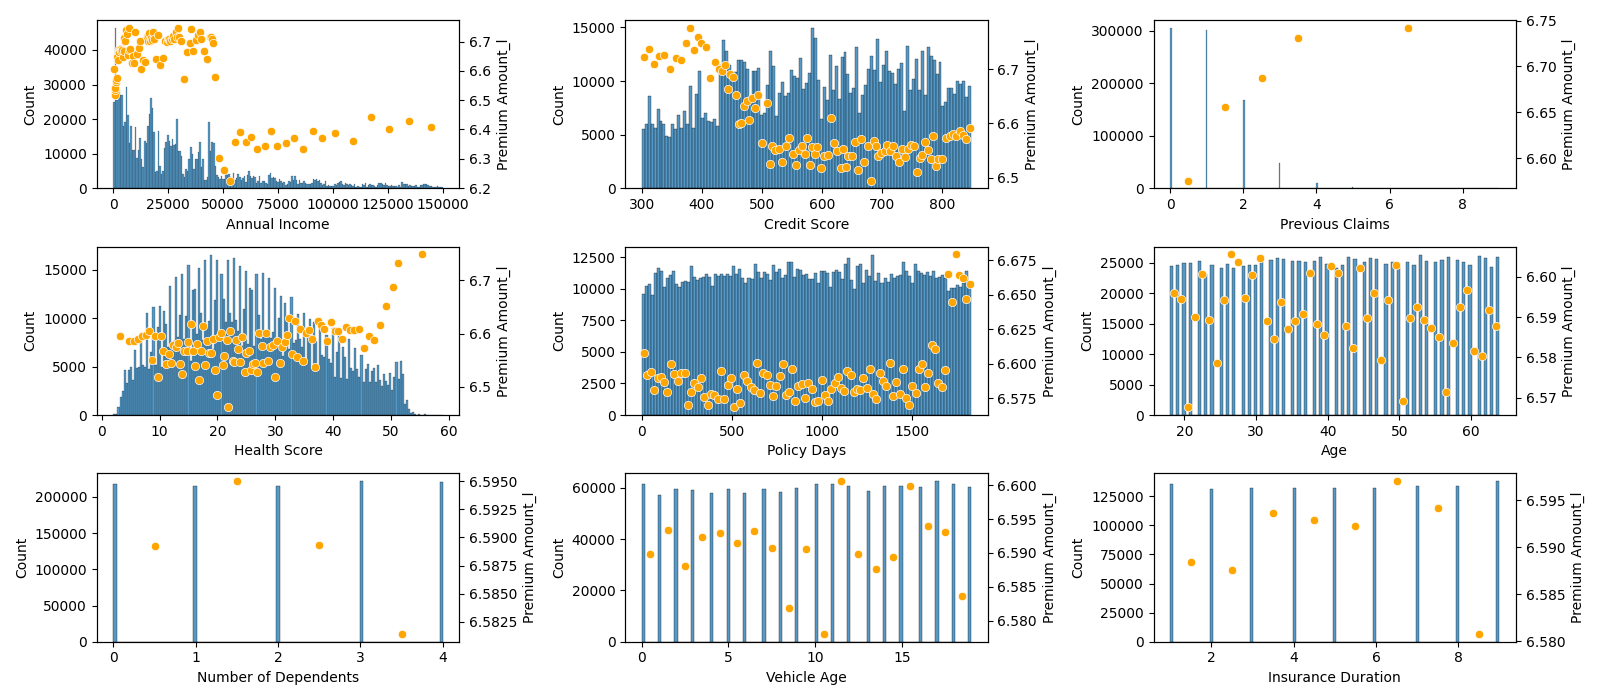

In [26]:
def hist_and_scatter(df, col, ax):
    sns.histplot(df[col], ax=ax)
    df_train.groupby(pd.qcut(df[col], q=100, duplicates='drop'), observed=True)[[target]].mean().assign(
        x = lambda x: x.index.map(lambda x: (x.left + x.right) / 2)
    ).rename(columns = {'x': col}).pipe(
        lambda x: sns.scatterplot(x, x = col, y = target, ax=ax.twinx(), color='orange')
    )
X = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter',
    lambda axes: [hist_and_scatter(df_train, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7)
)

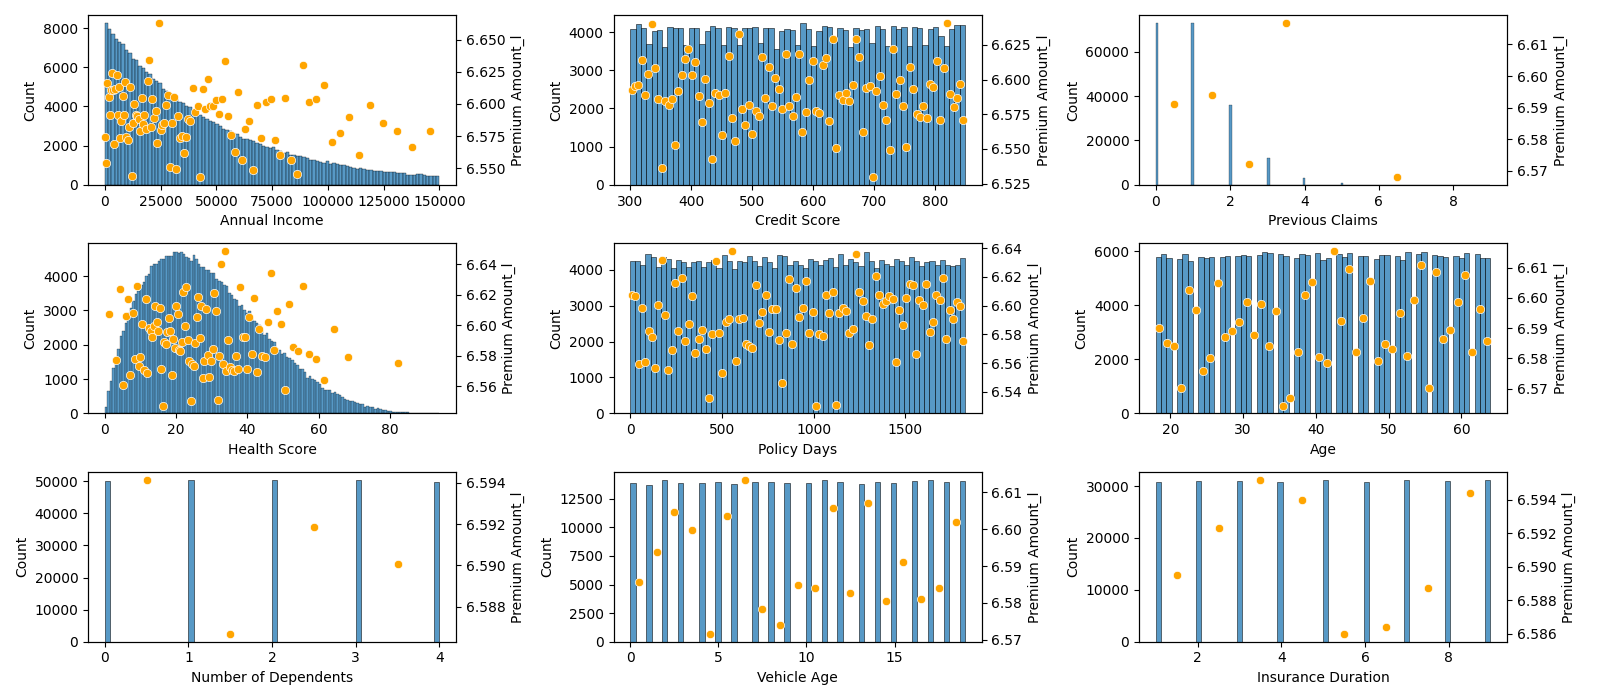

In [27]:
def hist_and_scatter(df, col, ax):
    sns.histplot(df[col], ax=ax)
    df_train.groupby(pd.qcut(df[col], q=100, duplicates='drop'), observed=True)[[target]].mean().assign(
        x = lambda x: x.index.map(lambda x: (x.left + x.right) / 2)
    ).rename(columns = {'x': col}).pipe(
        lambda x: sns.scatterplot(x, x = col, y = target, ax=ax.twinx(), color='orange')
    )
X = df_spearman_target.T['pvalue'].sort_values(ascending=True).index.tolist()    
sc.cache_fig('hist_and_scatter_org',
    lambda axes: [hist_and_scatter(df_org, i, ax) for i, ax in zip(X, axes)], 3, 3, figsize=(16, 7), redraw=0
)

# Missing Variables

In [28]:
pd.concat([
    df_train[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(train)').sort_values(ascending=False).to_frame().T,
    df_test[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(test)').sort_values(ascending=False).to_frame().T,
    df_org[X_cat + X_num].isna().mean().pipe(lambda x: x.loc[x > 0]).rename('na_rate(org)').sort_values(ascending=False).to_frame().T
], axis=0).fillna(0)

,Previous Claims,Occupation,Credit Score,Number of Dependents,Health Score,Annual Income,Age,Marital Status,Vehicle Age,Insurance Duration
na_rate(train),0.303358,0.298396,0.114902,0.091393,0.061730,0.037457,0.015588,0.015441,0.000005,8.333333e-07
na_rate(test),0.303503,0.298906,0.114314,0.091412,0.061811,0.037325,0.015611,0.015420,0.000004,2.500000e-06
na_rate(org),0.291501,0.291501,0.100000,0.100000,0.038001,0.050043,0.016801,0.017998,0.000000,0.000000e+00


In [29]:
if 'Previous Claims_isna' not in df_train.columns:
    X_isna = ['Previous Claims', 'Occupation', 'Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age', 'Marital Status']
    df_train = df_train.join(df_train[X_isna].rename(columns = lambda x: x + '_isna'))
    df_org = df_org.join(df_org[X_isna].rename(columns = lambda x: x + '_isna'))
    X_isna = [i + '_isna' for i in X_isna]

## Missing Value Processing

In [30]:
# 수치형 변수의 결측치를 0으로 채웁니다.
if 'Previous Clains_fz' not in df_train.columns:
    X_fn = ['Previous Claims', 'Credit Score', 'Number of Dependents', 'Health Score', 'Annual Income', 'Age']
    df_fz = df_train[X_fn].fillna(0).rename(columns = lambda x: x + '_fz')
    X_fz = df_fz.columns.tolist()
    df_train = df_train.join(df_fz)

In [31]:
# 명목형 변수의 결측치를 Unknown으로 채웁니다.
if 'Occupation_funk' not in df_train.columns:
    df_train['Occupation_funk'] = df_train['Occupation'].cat.add_categories('Unknown').fillna('Unknown')
    df_train['Marital Status_funk'] = df_train['Marital Status'].cat.add_categories('Unknown').fillna('Unknown')

# Train/Test/Org Difference

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_roc_auc_diff(df_0, df_1, X_input):
    df_diff = pd.concat([
        df_0[X_input].assign(is_1 = False),
        df_1[X_input].assign(is_1 = True)
    ], axis = 0)
    df_train_diff, df_test_diff = train_test_split(df_diff, train_size = 0.8, stratify = df_diff['is_1'])
    clf_diff = lgb.LGBMClassifier(random_state=123, verbose = 0)
    clf_diff.fit(df_diff[X_input], df_diff['is_1'], categorical_feature = X_cat)
    return (
        roc_auc_score(df_test_diff['is_1'], clf_diff.predict_proba(df_test_diff[X_input])[:, 1]),
        pd.Series(clf_diff.feature_importances_, index=X_input)
    )
(roc1, s_imp1), (roc2, s_imp2) = sc.cache_result('diff_result',
    lambda : (
        get_roc_auc_diff(df_train, df_test, X_cat + X_num),
        get_roc_auc_diff(df_train, df_org, X_cat + X_num + ['Premium Amount'] + X_isna)
    ), rerun=0
)
roc1, roc2

(0.5357095850911459, 0.8108993313550408)

In [33]:
s_imp2.sort_values(ascending=False).iloc[:15].to_frame().T

,Annual Income,Health Score,Premium Amount,Credit Score,Previous Claims,Marital Status_isna,Policy Days,Number of Dependents,Education Level,Age,Occupation_isna,Exercise Frequency,Vehicle Age,Age_isna,Annual Income_isna
0,883,757,650,399,150,72,67,11,4,3,2,1,1,0,0


Train은 Test와 구분이 어려운 것으로 보아 차이가 크지 않음을 알 수 있고,

Org와는 차이가 보입니다. Org 데이터를 포함하여 학습시키는 것은 성능의 개선을 주지 않을 가능성이 큽니다. 

In [34]:
from sklearn.metrics import mean_squared_error
def check_improve():
    df_org[target] = np.log(df_org['Premium Amount'] + 1e-7)
    df_train_2, df_valid = train_test_split(df_train, train_size = 0.8)
    return (
        mean_squared_error(
            df_valid[target],
            lgb.LGBMRegressor(random_state = 123, verbose=0).fit(df_train_2[X_cat + X_num], df_train_2[target]).predict(df_valid[X_cat + X_num])
        ),
        mean_squared_error(
            df_valid[target],
            pd.concat([df_train_2[X_cat + X_num + [target]], df_org[X_cat + X_num + [target]]])\
            .pipe(lambda x: lgb.LGBMRegressor(random_state = 123, verbose=0).fit(x[X_cat + X_num], x[target]).predict(df_valid[X_cat + X_num]))
        )
    )
sc.cache_result('check_improve', check_improve)

(1.1154423300794376, 1.1327478698101194)

# Analyze with ML

In [35]:
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.metrics import mean_squared_error
kf = KFold(5, random_state=123, shuffle=True)
ss = ShuffleSplit(1, random_state=123)

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size=validation_fraction)

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index=df.index),
    'score_func': lambda df, prds: mean_squared_error(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(),
    'return_train_scores': True,
    'y': target,
}

cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)

In [48]:
def gb_shap_learning_result(train_result, df, interaction = True):
    explainer = shap.TreeExplainer(train_result['model'])
    processor = train_result['preprocessor']
    result = {
        'X': pd.DataFrame(processor.transform(df), index=df.index, columns=train_result['variables'])
    }
    result['shap_values'] = explainer.shap_values(result['X'])
    if interaction:
        result['shap_interaction_values'] = explainer.shap_interaction_values(result['X'])
    return result

def cb_interaction_importance(train_result):
    s_name = pd.Series(train_result['variables'])
    return pd.DataFrame(
        train_result['model'].get_feature_importance(type = 'Interaction'),
        columns = ['Var1', 'Var2', 'Importance']
    ).assign(
        Var1 = lambda x: x['Var1'].map(s_name),
        Var2 = lambda x: x['Var2'].map(s_name),
    )

In [50]:
hparams = {
    'model_params': {'n_estimators': 100},
    'X_num': X_num, 'X_cat': X_ord + ['Marital Status_funk', 'Occupation_funk', 'Property Type'] + X_bool,
    'random_state': 123,
    'validation_fraction': 0.1
}
result = sc.cache_result(
    'cb', 
    lambda : sgml.cv(
        df_train, ss, hparams, config, cb_adapter, 
        result_proc = [sgml.cb_learning_result, partial(gb_shap_learning_result, df=df_train.sample(frac=0.1)), cb_interaction_importance]
    ), rerun=0
)

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/100 [00:00<?, ?it/s]

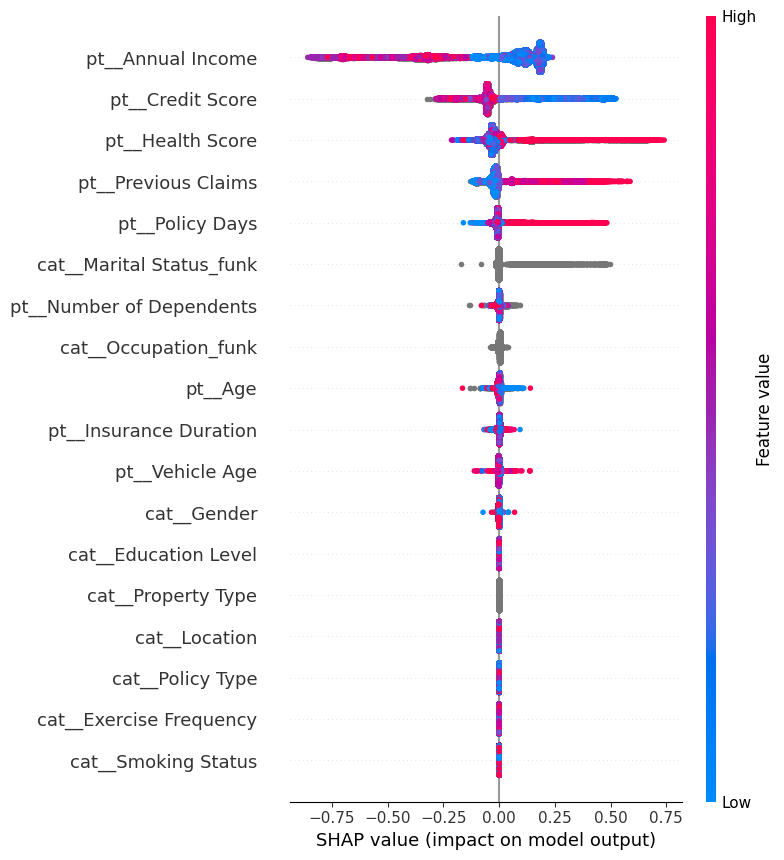

In [51]:
shap.summary_plot(result['model_result'][1]['shap_values'], result['model_result'][1]['X'])

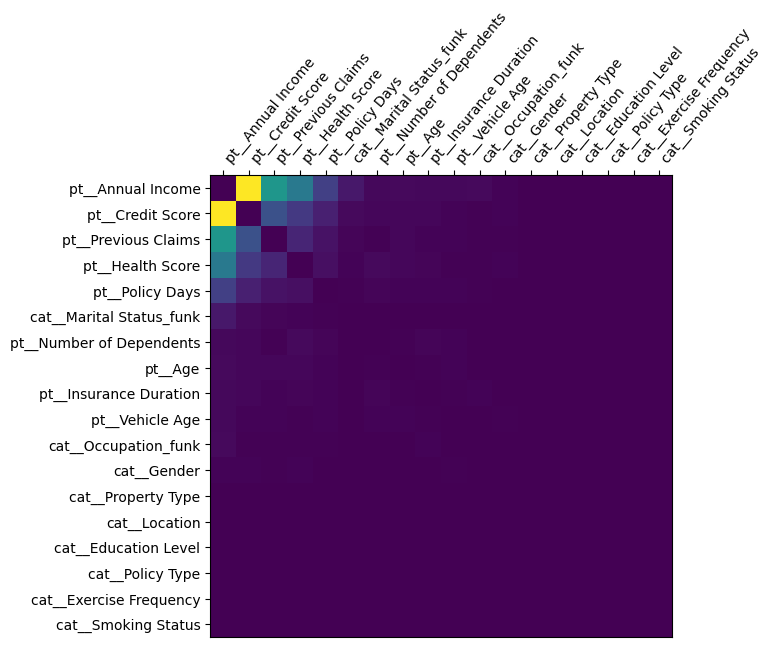

In [52]:
interaction_matrix = np.abs(result['model_result'][1]['shap_interaction_values']).sum(0)
for i in range(interaction_matrix.shape[0]):
    interaction_matrix[i, i] = 0
inds = np.argsort(-interaction_matrix.sum(0))[:20]
sorted_ia_matrix = interaction_matrix[inds, :][:, inds]
plt.figure(figsize=(10, 6))
plt.imshow(sorted_ia_matrix)
plt.yticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(sorted_ia_matrix.shape[0]),
    result['model_result'][1]['X'].columns[inds],
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()

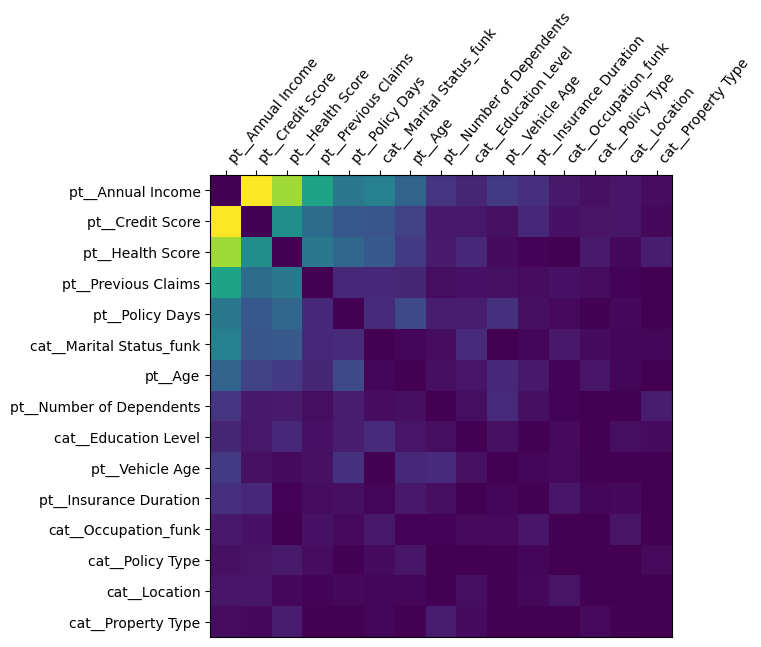

In [83]:
df_cb_inter = pd.concat([
    result['model_result'][2],
    result['model_result'][2].rename(columns={'Var1': 'Var2', 'Var2': 'Var1'})
], axis=0).pivot(index='Var1', columns='Var2').fillna(0)
s_sum = df_inter.sum()
df_cb_inter = df_cb_inter.iloc[np.argsort(-s_sum), np.argsort(-s_sum)]
plt.figure(figsize=(10, 6))
plt.imshow(df_cb_inter)
plt.yticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=0,
    horizontalalignment="right",
)
plt.xticks(
    range(df_cb_inter.shape[0]),
    df_cb_inter.columns.map(lambda x: x[1]),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
plt.show()